In [1]:
# Purpose: Plotting the spatial distribution of ocean heat content anomalies 
#          over the Argo period to compare with OBS
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 19. 06. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import matplotlib.patheffects as PathEffects

import warnings
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime


from cdo import *
cdo = Cdo()
import os
import sys

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]
from dask.distributed import Client
client = Client(n_workers=4)         # careful: do not run with 16 workers here as it will crash
client

Client Scheduler: tcp://127.0.0.1:36245 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 80.00 GiB


### Calculate linear temperature trend in ACCESS-OM2-1 simulations
This is done in the script spatial_maps_and_zonal_integral_of_accumulated_ocean_heat_content_and_net_sfc_heating_anomalies.ipynb so I do not have to do it anymore. Here I use the output of the CDO calculations from there

### Calculate OHC trends

In [2]:
%%time
base = '/g/data/e14/mv7494/access-om2/archive/'
run = ['1deg_jra55_iaf_branch2000_PI_Offset/','1deg_jra55_iaf_branch2000_trend/']
file = 'temp_iaf_ocean_1972-2017_clim_trend_removed.nc'
exp = ['clim','iaf','iaf_Southern', 'iaf_Northern', 'iaf_Tropics30SN', 'iaf_Pacific', 'iaf_Indian', 'iaf_Atlantic',
       'iaf_Wind', 'iaf_TempRad']
start_time = ['1972']; end_time = ['2017']

# dzt = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
area_t = xr.open_dataset(base+run[0]+'output201/ocean/ocean_grid.nc').area_t
dxt = xr.open_dataset(base+run[0]+'output201/ocean/ocean_grid.nc').dxt
dyt = xr.open_dataset(base+run[0]+'output201/ocean/ocean_grid.nc').dyt
rho_0 = 1035.0                       # [kg m^{-3}]
C_p = 3992.10322329649               # [J kg^{-1} K^{-1}]


# maps --------------------------------------------------------------------------------------------------------------------
for e in range(len(exp)): # loop through IAF_full, IAF_tropics and_IAF_extratropics
    if exp[e] != 'clim': print(exp[e]) # don't print out the clim/CTRL iteration of the loop
    temp_access = xr.open_dataset(base+run[1]+'trend_temp_'+exp[e]+'_PI_Offset_'+start_time[0]+'-'+end_time[0]+'.nc').temp
    dzt = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
    OHC_1deg_map      = (rho_0*C_p*temp_access*dzt).sum(['time','st_ocean']) # units of (J m-2 year-1)
    OHC_1deg_zonal    = (rho_0*C_p*temp_access*dzt*dxt).sum(['time','st_ocean','xt_ocean']) # units of (J m-1 year-1)
    
    if e == 1:
        OHC_1deg_map_iaf = OHC_1deg_map; OHC_1deg_zonal_iaf = OHC_1deg_zonal
    elif e == 2:
        OHC_1deg_map_iaf_Southern = OHC_1deg_map; OHC_1deg_zonal_iaf_Southern = OHC_1deg_zonal
    elif e == 3:
        OHC_1deg_map_iaf_Northern = OHC_1deg_map; OHC_1deg_zonal_iaf_Northern = OHC_1deg_zonal   
    elif e == 4:
        OHC_1deg_map_iaf_Tropics30SN = OHC_1deg_map; OHC_1deg_zonal_iaf_Tropics30SN = OHC_1deg_zonal  
    elif e == 5:
        OHC_1deg_map_iaf_Pacific = OHC_1deg_map; OHC_1deg_zonal_iaf_Pacific = OHC_1deg_zonal
    elif e == 6:
        OHC_1deg_map_iaf_Indian = OHC_1deg_map; OHC_1deg_zonal_iaf_Indian = OHC_1deg_zonal
    elif e == 7:
        OHC_1deg_map_iaf_Atlantic = OHC_1deg_map; OHC_1deg_zonal_iaf_Atlantic = OHC_1deg_zonal 
    elif e == 8:
        OHC_1deg_map_iaf_Wind = OHC_1deg_map; OHC_1deg_zonal_iaf_Wind = OHC_1deg_zonal
    elif e == 9:
        OHC_1deg_map_iaf_TempRad = OHC_1deg_map; OHC_1deg_zonal_iaf_TempRad = OHC_1deg_zonal 
        
        
# depth-latitude panels ---------------------------------------------------------------------------------------------------
for e in range(len(exp)): # loop through CTRL, IAF_full, IAF_tropics and_IAF_extratropics
    temp = xr.open_dataset(base+run[1]+'trend_temp_'+exp[e]+'_PI_Offset_'+start_time[0]+'-'+end_time[0]+'.nc').temp     
    # allocate xarray data
    if e ==0:        OHC_1deg_lat_depth_clim = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])
    elif e == 1:     OHC_1deg_lat_depth_iaf = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])
    elif e == 2:     OHC_1deg_lat_depth_Southern = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])
    elif e == 3:     OHC_1deg_lat_depth_Northern = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])
    elif e == 4:     OHC_1deg_lat_depth_Tropics30SN = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])    
    elif e == 5:     OHC_1deg_lat_depth_Pacific= (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])
    elif e == 6:     OHC_1deg_lat_depth_Indian = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])
    elif e == 7:     OHC_1deg_lat_depth_Atlantic = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])
    elif e == 8:     OHC_1deg_lat_depth_Wind = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])
    elif e == 9:     OHC_1deg_lat_depth_TempRad = (rho_0*C_p*temp*dxt).sum(['time','xt_ocean'])


# load in climatological temperature distribution as well
temp_clim_contour = xr.open_mfdataset(base+'1deg_jra55_rdf_branch2000_Control_PI_Offset/output*/ocean/ocean.nc').temp
temp_clim_contour = temp_clim_contour.mean(['time','xt_ocean']) - 273.15
# Wall time: 11.6 s

iaf
iaf_Southern
iaf_Northern
iaf_Tropics30SN
iaf_Pacific
iaf_Indian
iaf_Atlantic
iaf_Wind
iaf_TempRad
CPU times: user 7.39 s, sys: 2.08 s, total: 9.47 s
Wall time: 12.7 s


### Prepare data for time series to the left

--- IAF Full ---
--- Southern ---
--- Northern ---
--- Tropics30SN ---
--- Pacific ---
--- Indian ---
--- Atlantic ---
--- Wind ---
--- TempRad ---
CPU times: user 19.7 s, sys: 311 ms, total: 20 s
Wall time: 4min 34s


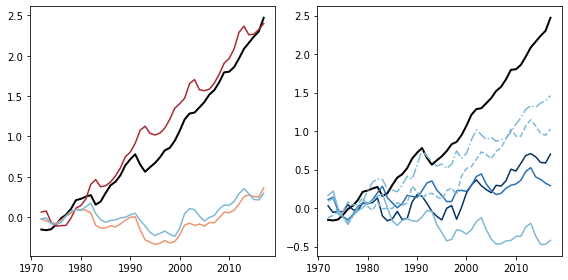

In [3]:
%%time
base = '/g/data/e14/mv7494/access-om2/archive/1deg_jra55_iaf_branch2000_'
run = ['IAF Full', 'Southern', 'Northern', 'Tropics30SN', 'Pacific', 'Indian', 'Atlantic', 'Wind', 'TempRad']

# # create temp_ctrl
# cdo.trend(input= base + 'iaf_branch2000_trend/temp_clim_PI_Offset_ocean_1972-2017.nc',
#           output = base + 'iaf_branch2000_trend/intercept_temp_clim_PI_Offset_1972-2017.nc ' +
#           base + 'iaf_branch2000_trend/trend_temp_clim_PI_Offset_1972-2017.nc', force=False)
# temp_ctrl = xr.open_mfdataset(base+'iaf_branch2000_trend/temp_clim_PI_Offset_ocean_1972-2017.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 

for f in range(len(run)):
    print('--- ' + run[f] + ' ---')
    # open the temperature array from which I previously removed the linear trend in the control simulation
    if f == 0:
        temp = xr.open_mfdataset(base+'trend/'+'temp_iaf_PI_Offset_ocean_1972-2017_clim_trend_removed.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 
        dzt = xr.open_mfdataset(base+'PI_Offset/output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
        area_t = xr.open_dataset(base+'PI_Offset/output201/ocean/ocean_grid.nc').area_t
    else:
        temp = xr.open_mfdataset(base+'trend/'+'temp_iaf_'+run[f]+'_PI_Offset_ocean_1972-2017_clim_trend_removed.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 
        dzt = xr.open_mfdataset(base+run[f]+'_PI_Offset/output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
        area_t = xr.open_dataset(base+run[f]+'_PI_Offset/output201/ocean/ocean_grid.nc').area_t

#     temp_ctrl['time'] = temp.time # copy over time dimension so I can subtract the drift
#     temp = temp - temp_ctrl # dedrift temperature
    # calculate OHC and take the 10-month average before loading into memory
    OHC = (rho_0*C_p*temp*area_t*dzt).sum(['xt_ocean','yt_ocean','st_ocean'])
#     OHC = OHC.rolling(time=5, center=True).mean().dropna('time').values # taking the five year centered rolling mean
    OHC = OHC - np.mean(OHC[0:9]) # subtract the 1972-1981 baseline period

    if f == 0:
        OHC_1deg_2000 = OHC.load()
    elif f == 1:
        OHC_1deg_EXP_Southern = OHC.load() 
    elif f == 2:
        OHC_1deg_EXP_Northern = OHC.load()
    elif f == 3:
        OHC_1deg_EXP_Tropics30SN = OHC.load()
    elif f == 4:
        OHC_1deg_EXP_Pacific = OHC.load()
    elif f == 5:
        OHC_1deg_EXP_Indian = OHC.load()
    elif f == 6:
        OHC_1deg_EXP_Atlantic = OHC.load()     
    elif f == 7:
        OHC_1deg_EXP_Wind = OHC.load()    
    elif f == 8:
        OHC_1deg_EXP_TempRad = OHC.load()    
        
# quick plotting
fig = plt.figure(figsize=(8,4),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0,0])
x = np.linspace(1972,2017,len(OHC_1deg_2000))
p1, = plt.plot(x, OHC_1deg_2000/1e23, c = 'k', label = 'ACCESS-OM2-1 IAF$_{\mathrm{FULL}}$', linewidth=2) # looks okay
p3, = plt.plot(x, OHC_1deg_EXP_Southern/1e23, c = rotblau[3],label = 'IAF$_{\mathrm{Southern}}$')
p4, = plt.plot(x, OHC_1deg_EXP_Northern/1e23, c = rotblau[6], label = 'IAF$_{\mathrm{Northern}}$') 
p6, = plt.plot(x, OHC_1deg_EXP_Tropics30SN/1e23, c = rotblau[14], label = 'IAF$_{\mathrm{TROPICS 30SN}}$') 
ax1 = plt.subplot(gs[0,1])
x = np.linspace(1972,2017,len(OHC_1deg_2000))
p1, = plt.plot(x, OHC_1deg_2000/1e23, c = 'k', label = 'IAF$_{\mathrm{FULL}}$', linewidth=2) # looks okay
p2, = plt.plot(x, OHC_1deg_EXP_Pacific/1e23, c = rotblau[20],label = 'IAF$_{\mathrm{PACIFIC}}$')
p3, = plt.plot(x, OHC_1deg_EXP_Indian/1e23, c = rotblau[17],label = 'IAF$_{\mathrm{INDIAN}}$')
p4, = plt.plot(x, OHC_1deg_EXP_Atlantic/1e23, c = rotblau[14],label = 'IAF$_{\mathrm{ATLANTIC}}$')
p4, = plt.plot(x, OHC_1deg_EXP_Wind/1e23, c = rotblau[14],label = 'IAF$_{\mathrm{ATLANTIC}}$', linestyle='--')
p4, = plt.plot(x, OHC_1deg_EXP_TempRad/1e23, c = rotblau[14],label = 'IAF$_{\mathrm{ATLANTIC}}$', linestyle='-.')

# Wall time: 4min 22s
# Wall time: 26min 43s...why?!

### Testing the plotting layout

In [4]:
def fancy_plot(axes_nr):
    '''
    This function creates my specifics for the global plot, i.e.
    coastlines, land colour, gridlines and labels (30°lat, 60°lon)
    input:
        - axes_nr -> number of subplot, i.e. ax1 for subplot(2,2,1)
    '''
    axes_nr.coastlines(resolution = '50m') # add coast lines
    # ticklabels on left and bottom only
    axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-80,-45,0,45,80], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "

    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)

    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
def fancy_plot2(axes_nr): # different function for the zonally-integrated depth-latitude plots
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    plt.gca().invert_yaxis() # reverse y axis so it goes from surface (0 m) down to 2000 m 
    axes_nr.set_ylim([2000,0]) # set plot limits
    axes_nr.set_xlim([-80,90])

    axes_nr.set_xticks([-80,-45,0,45,80])
    axes_nr.set_yticks([2000, 1500, 1000, 500, 0])

    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lat_formatter) # "       "       "
    
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    plt.ylabel('Depth (m)', fontsize=16)

### Basin-mask preparation: Southern Ocean begins at 38°S

In [5]:
# %%time
# fig = plt.figure(figsize=(20,5),tight_layout=True,facecolor='w',edgecolor='k')
# for b in range(5):
#     basin_mask = xr.open_mfdataset('/g/data/e14/mv7494/basin_mask_mom_1deg.nc').BASIN_MASK
#     if b == 0: # global mask   
#         for f in range(10): # replacing all the ocean with '1' values
#             basin_mask = basin_mask.where(basin_mask != f+1,1) # 
#         basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
#         basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
#         basin_global = basin # Southern Ocean
#         plt.subplot(2,3,b+1)
#         basin.plot(); index = 0
#     if b == 1:        index = 1 # Southern Ocean
#     if b == 2:        index = 2 # Atlantic
#     if b == 3:        index = 3 # Pacific
#     if b == 4:        index = 5 # Indian 
#     basin_mask = basin_mask.where(basin_mask != 4,2) # replace Arctic Ocean index values (i.e. 4) with 
#     basin = basin_mask.where(basin_mask == index) # only select one basin & squeeze to get rid of one dim
#     basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
#     if b != 0:
#         plt.subplot(2,3,b+1)
#         basin.plot()
#     if b == 1:        basin_southern = basin # Southern Ocean
#     if b == 2:        basin_atlantic = basin # Atlantic
#     if b == 3:        basin_pacific = basin # Pacific
#     if b == 4:        basin_indian = basin # Indian     

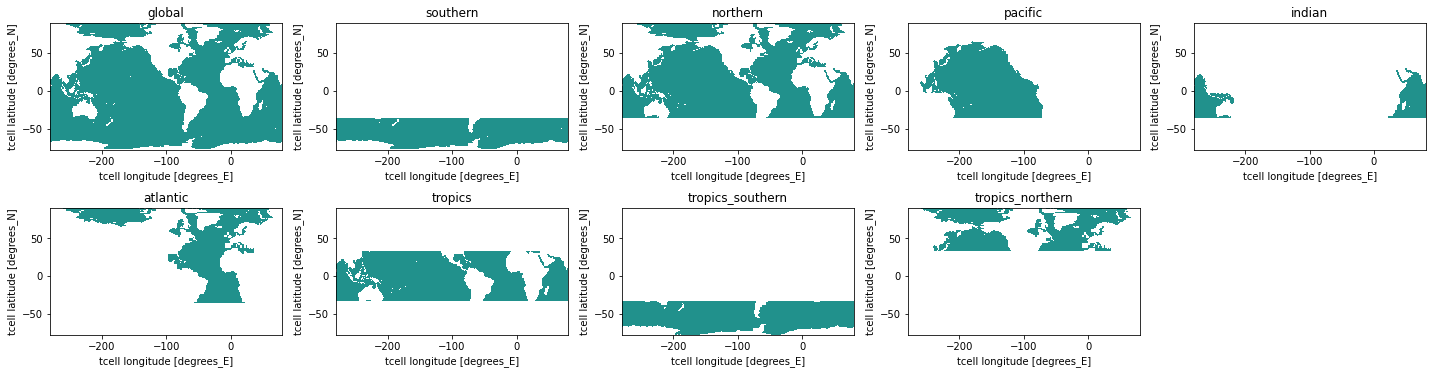

In [6]:
#### %%time
index = 1

# ---- define the southern boundary of the masks ---- #
south_bound = -36


fig = plt.figure(figsize=(20,10),tight_layout=True,facecolor='w',edgecolor='k')
titel = ['global','southern','northern','pacific','indian', 'atlantic', 'tropics', 'tropics_southern', 'tropics_northern']
for b in range(9):
    basin_mask = xr.open_mfdataset('/g/data/ik11/inputs/access-om2/input_236a3011/mom_1deg/basin_mask.nc').BASIN_MASK
    basin_mask = basin_mask.where(basin_mask != 4,2) # replace Arctic Ocean index values (i.e. 4) with 2
    basin_mask = basin_mask.where(basin_mask != 6,2) # add Mediterranean Sea to Atlantic Ocean
    basin_mask = basin_mask.where(basin_mask != 8,2) # add Hudson Bay to Atlantic Ocean
    basin_mask = basin_mask.where(basin_mask != 9,2) # add Baltic Sea to Atlantic Ocean
    basin_mask = basin_mask.where(basin_mask != 10,5) # add Red Sea to Indian Ocean
    basin = basin_mask.where(basin_mask == index) # only select one basin & squeeze to get rid of one dim

    if b == 0: # mask for GLOBAL
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
    if b == 1: # mask for SOUTHERN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
    if b == 2: # mask for NORTHERN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs 
    if b == 3:
        basin_mask = basin_mask.where(basin_mask != 1,3) # remove the Indian Ocean again
        basin_mask = basin_mask.where(basin_mask == 3) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.XT_OCEAN<-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-220) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where(basin_mask != 3,1) #
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-38) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-210), 0)
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 44°S/N
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
    
    if b == 4:
        basin_mask = basin_mask.where(basin_mask != 1,5) #
        basin_mask = basin_mask.where(basin_mask == 5) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-220) | (basin_mask.XT_OCEAN>-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-69) | (basin_mask.XT_OCEAN>22) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where(basin_mask !=5,1) #
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<42.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
    if b == 5:
        basin_mask = basin_mask.where(basin_mask != 1,2) #
        basin_mask = basin_mask.where(basin_mask == 2) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<22) | (basin_mask.XT_OCEAN>80) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where(basin_mask !=2,1) #
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim 
    if b == 6: # mask for the tropics_30SN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
            basin_mask = basin_mask.where((basin_mask.YT_OCEAN>-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
            basin_mask = basin_mask.where((basin_mask.YT_OCEAN<32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0)             
            basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
            basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
    if b == 7: # mask for TROPICS_SOUTHERN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
    if b == 8: # mask for TROPICS_NORTHERN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs 
    if b == 14: # mask for TROPICS_PACIFIC
        basin_mask = basin_mask.where(basin_mask != 1,3) # remove the Indian Ocean again
        basin_mask = basin_mask.where(basin_mask == 3) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.XT_OCEAN<-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-220) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where(basin_mask != 3,1) #
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
    if b == 15: # mask for TROPICS_INDIAN
        basin_mask = basin_mask.where(basin_mask != 1,5) #
        basin_mask = basin_mask.where(basin_mask == 5) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-220) | (basin_mask.XT_OCEAN>-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-69) | (basin_mask.XT_OCEAN>22) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where(basin_mask !=5,1) #
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
    if b == 16: # mask for TROPICS_ATLANTIC
        basin_mask = basin_mask.where(basin_mask != 1,2) #
        basin_mask = basin_mask.where(basin_mask == 2) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<22) | (basin_mask.XT_OCEAN>80) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin_mask = basin_mask.where(basin_mask !=2,1) #
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim

    basin = basin[0,:,:]    
    plt.subplot(4,5,b+1)
    basin.plot(add_colorbar=False);    plt.title(titel[b])
    if b == 0:        basin_global = basin       # Global Ocean
    if b == 1:        basin_southern = basin     # Southern Ocean
    if b == 2:        basin_northern = basin     # Northern Ocean
    if b == 3:        basin_pacific = basin      # Pacific
    if b == 4:        basin_indian = basin       # Indian 
    if b == 5:        basin_atlantic = basin     # Atlantic
    if b == 6:        basin_tropics = basin      # Tropics
    if b == 7:        basin_tropics_southern = basin 
    if b == 8:        basin_tropics_northern = basin
# Wall time: 1.96 s

### Calculate basin-wide values for Southern Ocean starting at 36°S

In [7]:
%%time
rounding_accuracy = 3
s2 = '-------------------------------------'
for exp in range(9):
    if exp == 0:
        map = OHC_1deg_map_iaf; s1 = 'IAF_Full'
    if exp == 1:
        map = OHC_1deg_map_iaf_Southern; s1 = 'IAF_Southern'
    if exp == 2:
        map = OHC_1deg_map_iaf_Northern; s1 = 'IAF_Northern'
    if exp == 3:
        map = OHC_1deg_map_iaf_Tropics30SN; s1 = 'IAF_Tropics30SN'    
    if exp == 4:
        map = OHC_1deg_map_iaf_Pacific; s1 = 'IAF_Pacific'
    if exp == 5:
        map = OHC_1deg_map_iaf_Indian; s1 = 'IAF_Indian'
    if exp == 6:
        map = OHC_1deg_map_iaf_Atlantic; s1 = 'IAF_Atlantic' 
    if exp == 7:
        map = OHC_1deg_map_iaf_Wind; s1 = 'IAF_Wind'
    if exp == 8:
        map = OHC_1deg_map_iaf_TempRad; s1 = 'IAF_TempRad' 
        
    print(s1)
    print(s2)
    myList = [0,0,0,0,0] # create empty list that I fill in with the basin-wide trends for the Global, Southern, Pacific, Indian and Atlantic Oceans
    for mask in range(5):
        if mask == 0: basin = basin_global  
        if mask == 1: basin = basin_southern
        if mask == 2: basin = basin_pacific
        if mask == 3: basin = basin_indian
        if mask == 4: basin = basin_atlantic
        
        a = basin.values * map.values # multiply values with the mask
        ds = xr.Dataset({'OHC': OHC_1deg_map_iaf, 'test': (('yt_ocean', 'xt_ocean'), a)}) # save back as data set so I can continue with xarray-like operations
        b = (ds.test*area_t).sum(['yt_ocean','xt_ocean']).values # multiply by area and take sum over the longitude and latitude dimensions
        b = np.round(b / 1e21, rounding_accuracy) # divide by 1e21 and then in the figure I write the exponent again
        b += 0. # if the value rounds to -0.0 then remove the sign -> array([-2., -1., -0.,  0.,  1.,  2.]) becomes
                                                                    # array([-2., -1.,  0.,  0.,  1.,  2.])
        # save the values into an array
        myList[mask] = b
    print('Global, Southern, Pacific, Indian, Atlantic')
    print(myList)
    print('')
    if exp == 0: myList_IAF = myList
    if exp == 1: myList_Southern = myList
    if exp == 2: myList_Northern = myList
    if exp == 3: myList_Tropics30SN = myList
    if exp == 4: myList_Pacific = myList
    if exp == 5: myList_Indian = myList
    if exp == 6: myList_Atlantic = myList
    if exp == 7: myList_Wind = myList
    if exp == 8: myList_TempRad = myList
# ok, so the lists include values for each of the basin masks
# Wall time: 1min 26s

IAF_Full
-------------------------------------
Global, Southern, Pacific, Indian, Atlantic
[5.563, 2.548, 1.71, 0.168, 1.137]

IAF_Southern
-------------------------------------
Global, Southern, Pacific, Indian, Atlantic
[5.882, 1.769, 2.269, 0.534, 1.31]

IAF_Northern
-------------------------------------
Global, Southern, Pacific, Indian, Atlantic
[0.379, 0.103, 0.807, -0.247, -0.284]

IAF_Tropics30SN
-------------------------------------
Global, Southern, Pacific, Indian, Atlantic
[0.477, 0.129, 0.149, -0.102, 0.3]

IAF_Pacific
-------------------------------------
Global, Southern, Pacific, Indian, Atlantic
[1.597, 0.117, 1.142, 0.16, 0.179]

IAF_Indian
-------------------------------------
Global, Southern, Pacific, Indian, Atlantic
[0.895, 0.249, 0.367, 0.168, 0.111]

IAF_Atlantic
-------------------------------------
Global, Southern, Pacific, Indian, Atlantic
[-1.169, -0.097, -0.303, -0.324, -0.445]

IAF_Wind
-------------------------------------
Global, Southern, Pacific, Ind

### Time series figure with histograms as panel (c)

Magnitude of OHC trajectory in IAF Full, Southern, Northern, Tropics30SN
[array(2.4718414e+23, dtype=float32), array(2.4010259e+23, dtype=float32), array(3.630897e+22, dtype=float32), array(2.971444e+22, dtype=float32)]
Magnitude of OHC trajectory in IAF Full, Wind, TempRad
[array(2.4718414e+23, dtype=float32), array(1.0246136e+23, dtype=float32), array(1.4602028e+23, dtype=float32)]
Magnitude of OHC trajectory in IAF Full, Southern, Northern, Tropics30SN
[array(2.4718414e+23, dtype=float32), array(2.4010259e+23, dtype=float32), array(3.630897e+22, dtype=float32), array(2.971444e+22, dtype=float32)]
Magnitude of OHC trajectory in IAF Full, Pacific, Indian, Atlantic
[array(2.4718414e+23, dtype=float32), array(7.0102545e+22, dtype=float32), array(2.88898e+22, dtype=float32), array(-4.2000732e+22, dtype=float32)]
CPU times: user 2.51 s, sys: 329 ms, total: 2.84 s
Wall time: 2.62 s


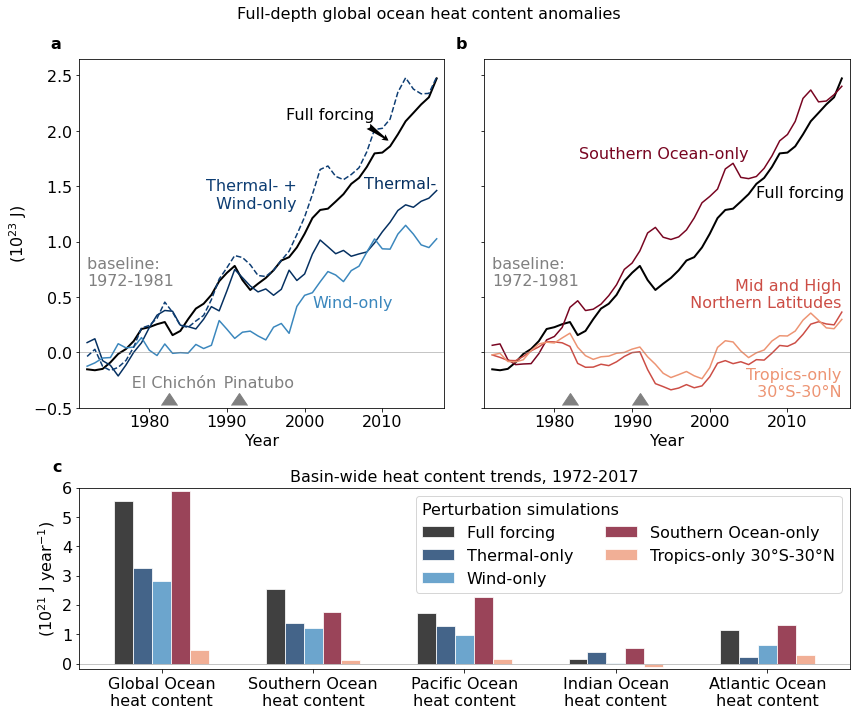

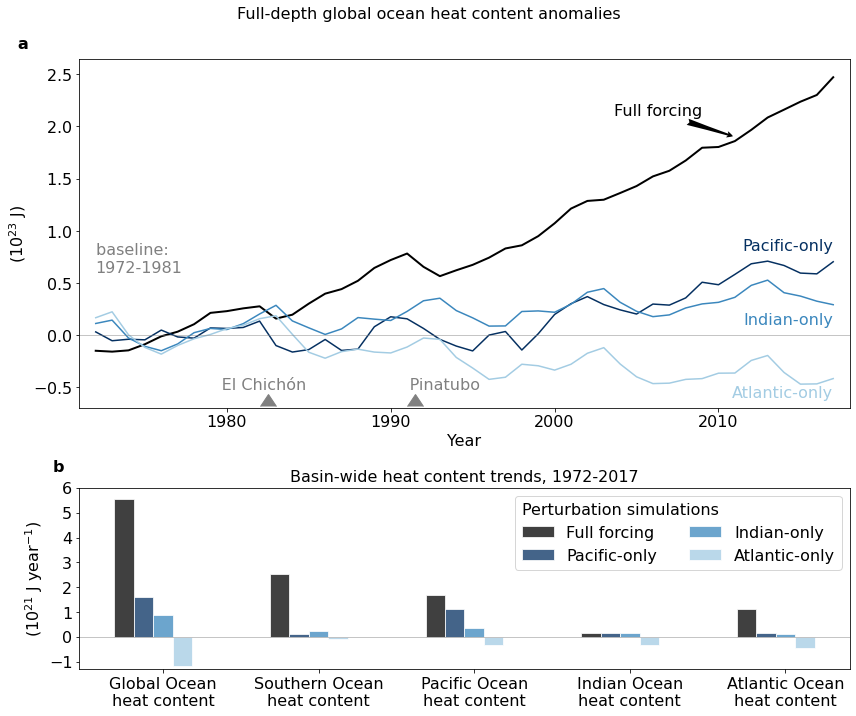

In [29]:
%%time
plot_range = [-78,90]


for s in range(2): #○ loop through two sets of experiments, creating two figures
    if s == 0:
        filename = 'ACCESS-OM2-1_accumulated_OHC_timeseries_for_main_manuscript_with_histograms_Wind_TempRad'
    if s == 1:
        filename = 'ACCESS-OM2-1_accumulated_OHC_timeseries_for_main_manuscript_with_histograms'

    # ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ #        
    # initialise figure
    fig = plt.figure(figsize=(12,10),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,.52]) 

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # --------------------------------------------------------------------------- #
    # --- subplot 1: Time series ------------------------------------------------ #
    # --------------------------------------------------------------------------- #
    if s == 0:
        ax1 = plt.subplot(gs[0,0]) # two subplots at the top
    else:
        ax1 = plt.subplot(gs[0,:]) # if basin-wide Pacific, Indian and Atlantic simulations, then only one elongated subplot at the top
    x = np.linspace(1972,2017,len(OHC_1deg_2000))
    p1, = plt.plot(x, OHC_1deg_2000/1e23, c = 'k', label = 'IAF$_{\mathrm{FULL}}$', linewidth=2) # looks okay
    if s == 0:
        p2, = plt.plot(x, OHC_1deg_EXP_TempRad/1e23, c = rotblau[20],label = 'Thermal-only')
        p3, = plt.plot(x, OHC_1deg_EXP_Wind/1e23, c = rotblau[16],label = 'Wind-only')
        p4, = plt.plot(x, (OHC_1deg_EXP_Wind+OHC_1deg_EXP_TempRad)/1e23, c = rotblau[19],label = 'COMBINED', linestyle='--')
    if s == 1:
        p2, = plt.plot(x, OHC_1deg_EXP_Pacific/1e23, c = rotblau[20],label = 'IAF$_{\mathrm{PACIFIC}}$')
        p3, = plt.plot(x, OHC_1deg_EXP_Indian/1e23, c = rotblau[16],label = 'IAF$_{\mathrm{INDIAN}}$')
        p4, = plt.plot(x, OHC_1deg_EXP_Atlantic/1e23, c = rotblau[13],label = 'IAF$_{\mathrm{ATLANTIC}}$')

    ax1.text(-.08, 1.03,'a', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    ax1.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9)
    # ticklabel  size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax1.yaxis.offsetText.set_fontsize(16)
    plt.text(1972, .6, 'baseline: \n1972-1981', color = 'grey', fontsize = 16)
    ax1.yaxis.major.formatter._useMathText = True # use scientific notation
    plt.locator_params(axis='x', nbins=7); plt.locator_params(axis='y', nbins=5) # seven ticks on x-axis and five on y-axis
    ax1.set_ylabel('(10$^{23}$ J)', fontsize=16); ax1.set_xlabel('Year', fontsize=16)

    plt.locator_params(axis='y', nbins=7)   # six ticks on y-axis

    # legend labels
    plt.text(2009, +2.1, 'Full forcing', color = 'k', fontsize = 16, horizontalalignment='right')
    # adding arrow   # end_coords, start_coords
    ax1.annotate('', xy=(2011, 1.9), xytext=(2008, 2.05),xycoords='data',
                 size=16,arrowprops=dict(facecolor='k', ec = 'none',arrowstyle="fancy"))
    if s == 0:
        plt.text(2017, 1.48,  'Thermal-', color = rotblau[20], fontsize = 16, horizontalalignment='right')
        plt.text(2001,   .4,  'Wind-only', color = rotblau[16], fontsize = 16, horizontalalignment='left')
        plt.text(1999,  1.3,  'Thermal- +\n Wind-only', color = rotblau[19], fontsize = 16, horizontalalignment='right')
       
        # plot volcano markers
        plt.plot(1982.5, -.37, marker=6, markersize=16, color = 'grey')
        plt.plot(1991.5, -.37, marker=6, markersize=16, color = 'grey')
        # add fancy label for volcanoes
        plt.text(1981.5, -.32, '     El Chichón', color = 'grey', fontsize = 16, horizontalalignment = 'center')
        plt.text(1992.5, -.32, '     Pinatubo', color = 'grey', fontsize = 16, horizontalalignment = 'center')
    if s == 1:
        plt.text(2017, .81, 'Pacific-only', color = rotblau[20], fontsize = 16, horizontalalignment='right')
        plt.text(2017, +.1,  'Indian-only', color = rotblau[16], fontsize = 16, horizontalalignment='right')
        plt.text(2017, -.6,  'Atlantic-only', color = rotblau[13], fontsize = 16, horizontalalignment='right')
        
        # plot volcano markers
        plt.plot(1982.5, -.57, marker=6, markersize=16, color = 'grey')
        plt.plot(1991.5, -.57, marker=6, markersize=16, color = 'grey')
        # add fancy label for volcanoes
        plt.text(1981.5, -.53, '     El Chichón', color = 'grey', fontsize = 16, horizontalalignment = 'center')
        plt.text(1992.5, -.53, '     Pinatubo', color = 'grey', fontsize = 16, horizontalalignment = 'center')
        
    if s == 0:
        plt.ylim(top = 2.65, bottom = -.5); plt.xlim(1971,2018)
    if s == 1:
        plt.ylim(top = 2.65, bottom = -.7); plt.xlim(1971,2018)
        
        

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # --------------------------------------------------------------------------- #
    # --- subplot 2: Time series ------------------------------------------------ #
    # --------------------------------------------------------------------------- #
    if s == 0:
        ax1 = plt.subplot(gs[0,1])
        x = np.linspace(1972,2017,len(OHC_1deg_2000))

        p1, = plt.plot(x, OHC_1deg_2000/1e23, c = 'k', label = 'IAF Full', linewidth=2) # looks okay
        p3, = plt.plot(x, OHC_1deg_EXP_Southern/1e23, c = rotblau[1],label = 'Southern Ocean')
        p4, = plt.plot(x, OHC_1deg_EXP_Northern/1e23, c = rotblau[4], label = 'North of 44$^{\circ}$S') 

        p6, = plt.plot(x, OHC_1deg_EXP_Tropics30SN/1e23, c = rotblau[6], label = 'Tropics 30$^{\circ}$S-30$^{\circ}$N') 
        # p5, = plt.plot(x, OHC_1deg_EXP_extratropics_30SN/1e23, c = rotblau[19], label = 'IAF$_{\mathrm{EXTRATROPICS 30SN}}$')         

        ax1.text(-.08, 1.03, 'b', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        ax1.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9)
        #     ax1.set_xlabel('Year', fontsize=16); ax1.set_ylabel('(10$^{23}$ J)', fontsize=16)
        # ticklabel  size
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax1.yaxis.offsetText.set_fontsize(16)
        ax1.yaxis.major.formatter._useMathText = True # use scientific notation

        ax1.set_yticklabels([]); ax1.set_xlabel('Year', fontsize=16)

        #     plt.text(1972, +.35, 'baseline: 1972-1981', color = 'grey', fontsize = 16)
        # legend labels
        plt.text(2006, 1.4, 'Full forcing', color = 'k', fontsize = 16, horizontalalignment='left')
        plt.text(2005, +1.75, 'Southern Ocean-only', color = rotblau[1], fontsize = 16, horizontalalignment='right')
        plt.text(2017, +.4, 'Mid and High\n Northern Latitudes', color = rotblau[4], fontsize = 16, horizontalalignment='right')
        # plt.text(2005, +1.5, 'Extratropics outside\n 30°S-30°N', color = rotblau[19], fontsize = 16, horizontalalignment='right')
        plt.text(2017, -.4, 'Tropics-only\n 30°S-30°N', color = rotblau[6], fontsize = 16, horizontalalignment='right')

        plt.text(1972, .6, 'baseline: \n1972-1981', color = 'grey', fontsize = 16)
        plt.locator_params(axis='x', nbins=7); plt.locator_params(axis='y', nbins=5) # seven ticks on x-axis and five on y-axis
        if s == 0:
            # plot volcano markers
            plt.plot(1982, -.37, marker=6, markersize=16, color = 'grey')
            plt.plot(1991, -.37, marker=6, markersize=16, color = 'grey')
            plt.ylim(top = 2.65, bottom = -.5); plt.xlim(1971,2018)
        if s == 1:
            # plot volcano markers
            plt.plot(1982, -.57, marker=6, markersize=16, color = 'grey')
            plt.plot(1991, -.57, marker=6, markersize=16, color = 'grey')
            # add fancy label for volcanoes
            plt.text(1982, -.53, '     El Chichón', color = 'grey', fontsize = 16, horizontalalignment = 'center')
            plt.text(1991, -.53, '     Pinatubo', color = 'grey', fontsize = 16, horizontalalignment = 'center')

            plt.ylim(top = 2.65, bottom = -.7); plt.xlim(1971,2018)
        plt.locator_params(axis='y', nbins=7)   # six ticks on y-axis

    # add global title over the two subplots
    st = fig.suptitle('Full-depth global ocean heat content anomalies', fontsize=16); st.set_y(.99)

    

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # --------------------------------------------------------------------------- #
    # --- subplot 2: Histograms ------------------------------------------------- #
    # --------------------------------------------------------------------------- #
    ax1 = plt.subplot(gs[1,:])

    # set width of bar
    barWidth = 0.125
    # set height of bar

    # Set position of bar on X axis
    r1 = np.arange(len(myList_IAF))
    r2 = [x + barWidth for x in r1]; r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]; r5 = [x + barWidth for x in r4]
    if s == 1:
        r6 = [x + barWidth for x in r5]

    # Make the plot
    plt.bar(r1, myList_IAF, color='k', width=barWidth, edgecolor='white', label='Full forcing', alpha=.75)
    if s == 0:
        plt.bar(r2, myList_TempRad, color=rotblau[20], width=barWidth, edgecolor='white', label='Thermal-only', alpha=.75)   
        plt.bar(r3, myList_Wind, color=rotblau[16], width=barWidth, edgecolor='white', label='Wind-only', alpha=.75)
        plt.bar(r4, myList_Southern, color=rotblau[1], width=barWidth, edgecolor='white', label='Southern Ocean-only', alpha=.75)
        plt.bar(r5, myList_Tropics30SN, color=rotblau[6], width=barWidth, edgecolor='white', label='Tropics-only 30°S-30°N', alpha=.75)
    if s == 1:
        plt.bar(r2, myList_Pacific, color=rotblau[20], width=barWidth, edgecolor='white', label='Pacific-only', alpha=.75)
        plt.bar(r3, myList_Indian, color=rotblau[16], width=barWidth, edgecolor='white', label='Indian-only', alpha=.75)
        plt.bar(r4, myList_Atlantic, color=rotblau[13], width=barWidth, edgecolor='white', label='Atlantic-only', alpha=.75)
    ax1.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9)

    # Add xticks on the middle of the group bars
    plt.yticks(fontsize=16)
    plt.xticks([r + 2*barWidth for r in range(len(myList_IAF))], ['Global Ocean\nheat content', 'Southern Ocean\nheat content', 'Pacific Ocean\nheat content', 
                                                                  'Indian Ocean\nheat content', 'Atlantic Ocean\nheat content'], fontsize=16)
    if s == 0:
        plt.ylim(-.2,6)
    if s == 1:
        plt.ylim(-1.3,6)  
    ax1.set_ylabel('(10$^{21}$ J year$^{-1}$)', fontsize=16)

    # Create legend & legend title
    h1 = ax1.legend(fontsize=16, ncol=2); h1.set_title('Perturbation simulations',prop={'size':16}); h1._legend_box.align = "left"

    # add panel (c) or (b) label and panel title
    if s == 0: panel_label = 2
    if s == 1: panel_label = 1
    ax1.text(-.035, 1.09, string.ascii_lowercase[panel_label], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    plt.title('Basin-wide heat content trends, 1972-2017', fontsize=16)

    # --------------------------------------------------------------------------- #
    # --- saving as 300 dpi .PNG image in specified folder ---------------------- #
    # --- end of script --------------------------------------------------------- #
    plt.savefig(save + filename, dpi=300, facecolor='w',  edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
    # --- end of script --------------------------------------------------------- # 
    # Wall time: 1.2 s
    
    # print maximum OHC value in 2017
    if s == 0:
        print('Magnitude of OHC trajectory in IAF Full, Southern, Northern, Tropics30SN')
        print([OHC_1deg_2000[-1].values, OHC_1deg_EXP_Southern[-1].values, OHC_1deg_EXP_Northern[-1].values, OHC_1deg_EXP_Tropics30SN[-1].values])
        print('Magnitude of OHC trajectory in IAF Full, Wind, TempRad')
        print([OHC_1deg_2000[-1].values, OHC_1deg_EXP_Wind[-1].values, OHC_1deg_EXP_TempRad[-1].values])
    if s == 1:
        print('Magnitude of OHC trajectory in IAF Full, Southern, Northern, Tropics30SN')
        print([OHC_1deg_2000[-1].values, OHC_1deg_EXP_Southern[-1].values, OHC_1deg_EXP_Northern[-1].values, OHC_1deg_EXP_Tropics30SN[-1].values])
        print('Magnitude of OHC trajectory in IAF Full, Pacific, Indian, Atlantic')
        print([OHC_1deg_2000[-1].values, OHC_1deg_EXP_Pacific[-1].values, OHC_1deg_EXP_Indian[-1].values,  OHC_1deg_EXP_Atlantic[-1].values])

CPU times: user 2.48 s, sys: 346 ms, total: 2.82 s
Wall time: 4.47 s


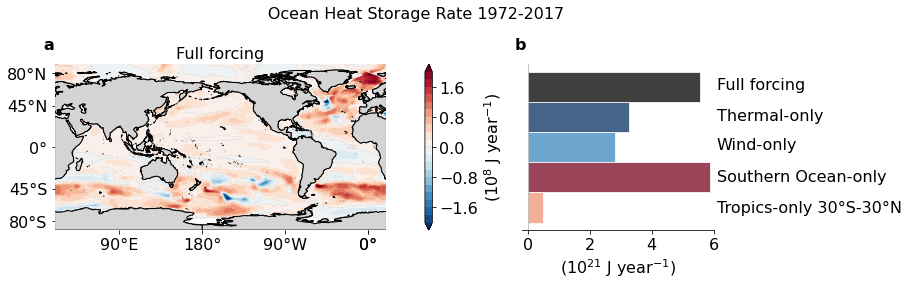

In [16]:
%%time
def fancy_plot(axes_nr):
    '''
    This function creates my specifics for the global plot, i.e.
    coastlines, land colour, gridlines and labels (30°lat, 60°lon)
    input:
        - axes_nr -> number of subplot, i.e. ax1 for subplot(2,2,1)
    '''
    axes_nr.coastlines(resolution = '50m') # add coast lines
    # ticklabels on left and bottom only
    axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-80,-45,0,45,80], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "

    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
# -------------------------------------------------------------------------------------------------

filename = 'ACCESS-OM2-1_OHC_trend_map_and_hist_cover_letter'

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ #        
# initialise figure
fig = plt.figure(figsize=(16,4),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1, 2, width_ratios=[1,.25]) 

# --------------------------------------------------------------------------- #
# --- subplot 1: SPATIAL MAP OHC TRENDS ------------------------------------- #
# --------------------------------------------------------------------------- #
# longitude starting at Cape Agulhas (20°E) so that I have Indian Ocean, Pacific Ocean, Atlantic Ocean without breaks
ax1 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=200))
ax1.set_extent([1, 360, -90,90], crs=ccrs.PlateCarree())

p3 = (OHC_1deg_map_iaf/1e8).plot.contourf(cmp='RdBu_r',levels= np.linspace(-2,2,num=21),add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p22 = (OHC_1deg_map_iaf/1e8).plot.contour(levels=[0], linewidths=.1, colors='grey', transform=ccrs.PlateCarree())

fancy_plot(ax1) # overwrite x-axis tick (i.e. longitude) labels

# add colour bar
cb = plt.colorbar(p3, shrink=1, orientation='vertical'); cb.set_label(label='(10$^{8}$ J year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks()
cb.add_lines(p22) # add contours to colour bar

ax1.text(-.035, 1.09, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
plt.gca().outline_patch.set_visible(False)
plt.title('Full forcing', fontsize=16)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# --------------------------------------------------------------------------- #
# --- subplot 2: Histograms ------------------------------------------------- #
# --------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[0,1])

# set width of bar
barWidth = 0.125
# set height of bar

# Set position of bar on X axis
r1 = np.arange(1)
r2 = [x + barWidth for x in r1]; r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]; r5 = [x + barWidth for x in r4]
# if s == 1:
#     r6 = [x + barWidth for x in r5]

# Make the plot
plt.barh(r5, myList_IAF[0], color='k', height=barWidth, edgecolor='white', label='Full forcing', alpha=.75, align='center')
plt.barh(r4, myList_TempRad[0], color=rotblau[20], height=barWidth, edgecolor='white', label='Thermal-only', alpha=.75, align='center')
plt.barh(r3, myList_Wind[0], color=rotblau[16], height=barWidth, edgecolor='white', label='Wind-only', alpha=.75, align='center')
plt.barh(r2, myList_Southern[0], color=rotblau[1], height=barWidth, edgecolor='white', label='Southern Ocean-only', alpha=.75)
plt.barh(r1, myList_Tropics30SN[0], color=rotblau[6], height=barWidth, edgecolor='white', label='Tropics-only 30°S-30°N', alpha=.75)

plt.text(6.1,  .49, 'Full forcing', fontsize=16)
plt.text(6.1,  .36, 'Thermal-only', fontsize=16)
plt.text(6.1,  .24, 'Wind-only', fontsize=16)
plt.text(6.1,  .11, 'Southern Ocean-only', fontsize=16)
plt.text(6.1, -.02, 'Tropics-only 30°S-30°N', fontsize=16)


ax1.axvline(x= 0, c = 'grey', linewidth = .5, alpha = .9)
# ax1.yaxis.tick_right(); ax1.yaxis.set_label_position("right")
# Add xticks on the middle of the group bars
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
# names = ['Full forcing', 'Buoyancy-only', 'Wind-only', 'Southern Ocean-only', 'Tropics-only 30°S-30°N']
ax1.set_yticklabels([]); ax1.set_yticks([])
# ax1.set_yticklabels(names,rotation_mode='anchor', ha='right', fontsize=16)
plt.xlim(-.2,6)
ax1.set_xlabel('(10$^{21}$ J year$^{-1}$)', fontsize=16)


# add panel (c) or (b) label and panel title
if s == 0: panel_label = 2
if s == 1: panel_label = 1
ax1.text(-.035, 1.09, string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
# plt.title('Basin-wide ocean heat content trends, 1972-2017', fontsize=16)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(False) # keep only x-axis

plt.suptitle('                               Ocean Heat Storage Rate 1972-2017', fontsize=16) # title

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + filename, dpi=300, facecolor='w',  edgecolor='w',          #
            orientation='landscape', papertype=None,                          #
            format=None, transparent=False, bbox_inches='tight',              #
            pad_inches=0.1, metadata=None)                                    #
# --- end of script --------------------------------------------------------- # 
# Wall time: 1.2 s

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #